# Test image ==> croping question rerion

In [1]:
from imutils.perspective import four_point_transform
from skimage.measure import compare_ssim
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

from matplotlib import interactive
interactive(True)

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
def show(img,figsize=(10,10)):

    cmap = plt.cm.OrRd
    cmap.set_bad(color='black')
    
    
    if type(img) != list:
        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='gray')
    else:
        ncols=len(img)
        fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=figsize)
        for i in range(ncols):
            axes[i].imshow(img[i], cmap='gray')
    plt.show()

(2339, 1653, 3) (2464, 1667, 3)


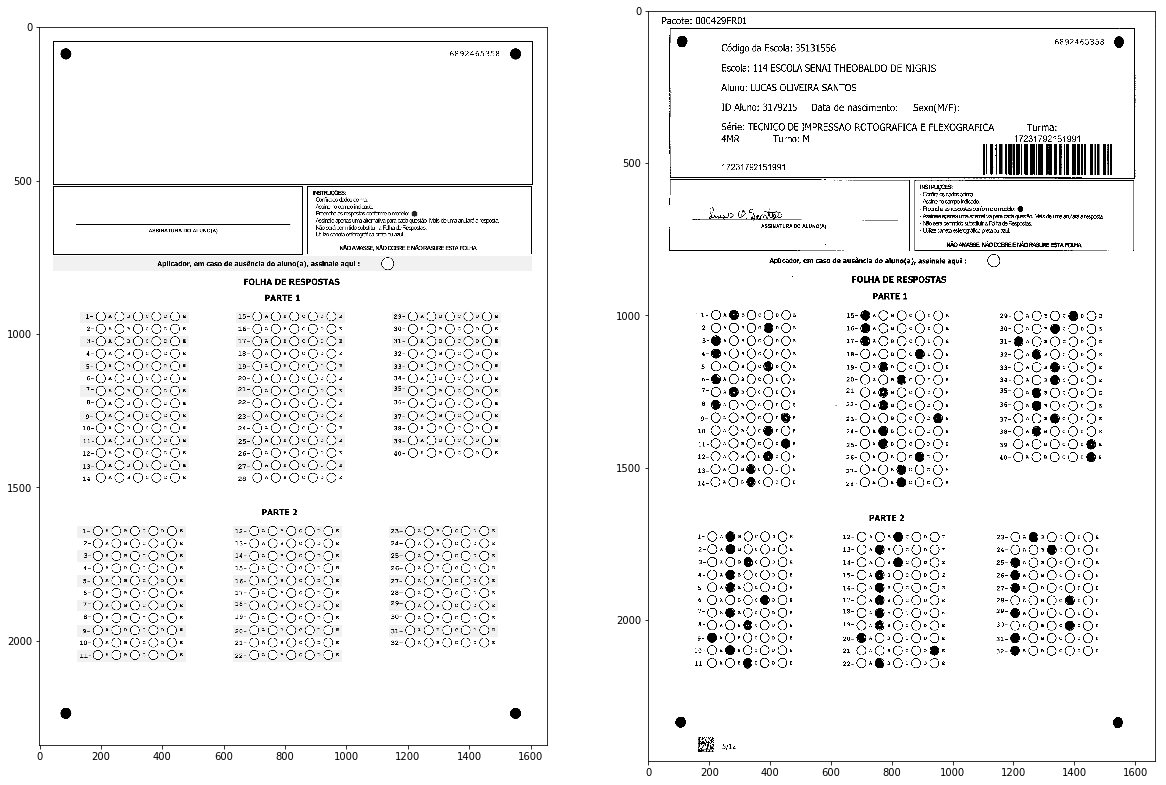

In [40]:
path_tmp = './templates/png/PT_AVALIA_40_32_AE.png'
path_img = 'LOTE3 - NOVOS EXEMPLOS/png/40_17231792151991.png'

part2 = 13

template = cv2.imread(path_tmp)
image = cv2.imread(path_img)

print(template.shape, image.shape)
show([template, image], (20,20))

In [43]:
def getTips(image, imshow=False):
    
    h,w,c = image.shape
    
    s = int(0.08*h)

    p0 = (int(0.025*h), int(0*w))
    p1 = (int(0.025*h), int(w-s))
    p2 = (int(h)-s, int(0*w))
    p3 = (int(h)-s, int(w-s))

    tips = [p0,p1,p2,p3]
    tests = []

    for n,(y,x) in enumerate(tips):

        test = image[y:y+s, x:x+s].copy()
        gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#         circles = cv2.HoughCircles(gray, 
#                                    cv2.HOUGH_GRADIENT, 1.3, 200, 
#                                    param1=10,param2=35,minRadius=0,maxRadius=0)

        circles = cv2.HoughCircles(gray, 
                           cv2.HOUGH_GRADIENT, 1,300, 
                           param1=20,param2=10,minRadius=13,maxRadius=0)
        if circles is not None:
            for i in circles[0,:]:
                cv2.circle(test,(i[0],i[1]),i[2],(0,255,0),2)
                cv2.circle(test,(i[0],i[1]),2,(0,255,0),3)     
                tips[n] = (x+i[0], y+i[1])
                
        if imshow: tests += [test]
    if imshow: show(tests)
        
    return np.array(tips)

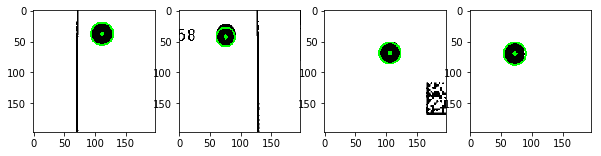

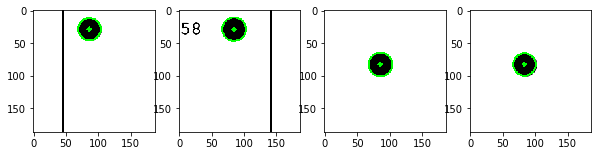

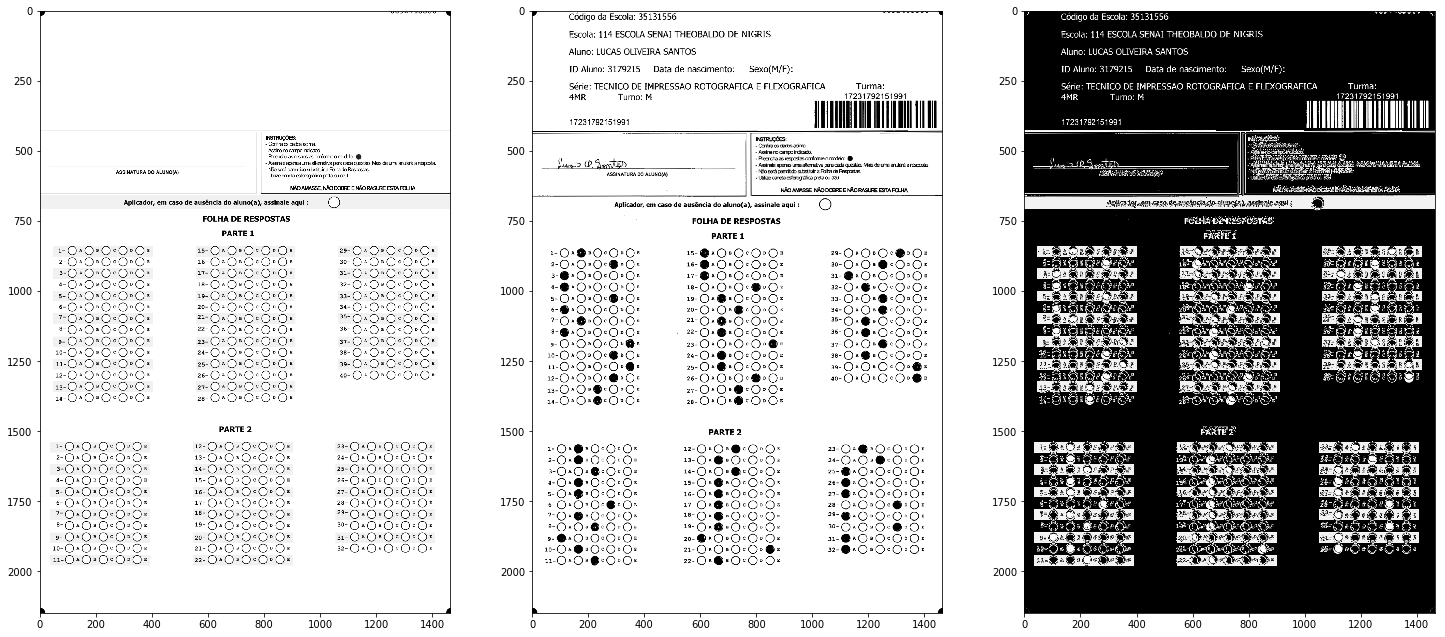

In [45]:
warped_img = four_point_transform(image, getTips(image, imshow=True))
warped_tmp = four_point_transform(template, getTips(template, imshow=True))

warped_img = cv2.resize(warped_img, warped_tmp.shape[0:2][::-1])

show([warped_tmp ,warped_img, warped_tmp-warped_img], (25,25))

In [46]:
def SSIM(imageA, imageB, imshow=False):
    
    imageA = imageA.copy()
    imageB = imageB.copy()
    
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    (score, diff) = compare_ssim(grayA, grayB, full=True)
    
    if imshow:
        diff = (diff * 255).astype("uint8")
        print("SSIM: {}".format(score))

        # threshold the difference image, followed by finding contours to
        # obtain the regions of the two input images that differ
        thresh = cv2.threshold(diff, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)

        cnts = cnts[0] if imutils.is_cv2() else cnts[1]

        # loop over the contours
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)

        show([imageA, imageB, diff, thresh], (25,20))

    return score

SSIM: 0.6412059706999643


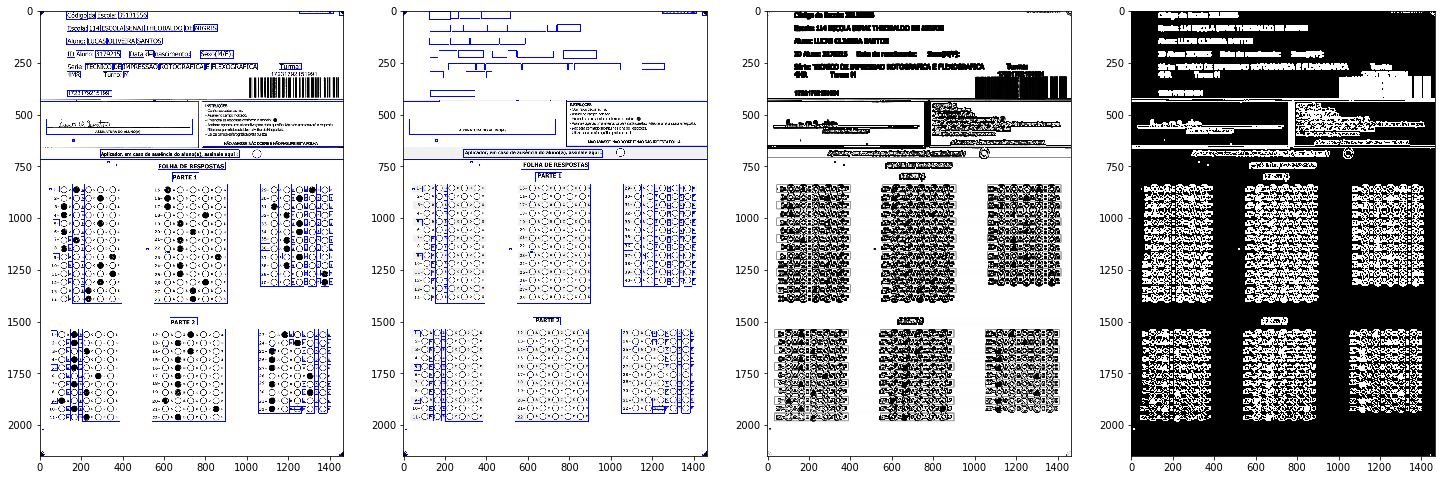

0.6412059706999643

In [47]:
SSIM(warped_img, warped_tmp, imshow=True)

In [48]:
def option_location(image, imshow=False):
    
    test = image.copy()
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    warped = gray.copy()

    thresh = cv2.threshold(warped, 0,127,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    ###################################################################
    # loop over the contours
    
    option_cnts = []
    for c in cnts:
        # compute the bounding box of the contour, then use the
        # bounding box to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(c)

        _w = _h = 18.5
        
        if(w >= _w and h >= _h and np.abs(w-h)<4): 
            circles = cv2.HoughCircles(gray[y:y+h, x:x+w], 
                                       cv2.HOUGH_GRADIENT, 1,100, 
                                       param1=20,param2=10,minRadius=13,maxRadius=0)
            if circles is not None:
                for i in circles[0,:]:
                    cv2.circle(test[y:y+h, x:x+w],(i[0],i[1]),i[2],(0,255,0),2)
                    cv2.circle(test[y:y+h, x:x+w],(i[0],i[1]),2,(0,255,0),3)
                option_cnts.append(c)
        
    show(test, (10,10))
                
    ###################################################################
    # count marked ops

    # questionCnts = contours.sort_contours(questionCnts,method="left-to-right")[0]
#     option_cnts = contours.sort_contours(option_cnts,method="top-to-bottom")[0]
    
    # print("Pontos identificados:",len(option_cnts))
    return option_cnts

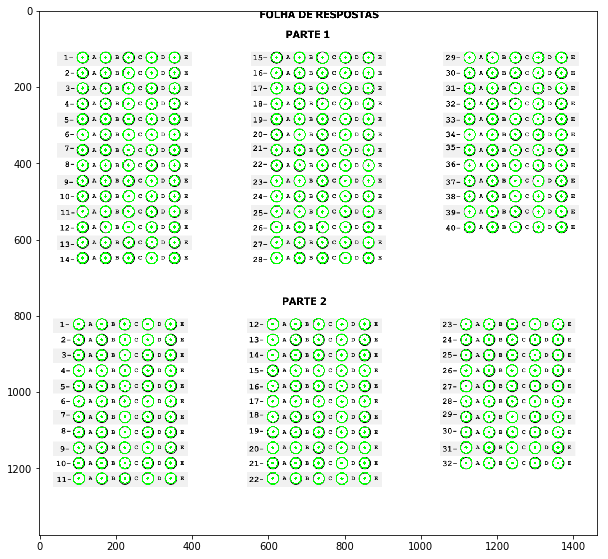

In [49]:
h,w,c = warped_tmp.shape

option_locations = option_location(warped_tmp[int(0.34*h):int(0.98*h)][:])

In [50]:
def isdarker(piece, tresh=0.30):
    "this function ..."
    "cluster image colors => copare to tresh hold => return true if image is darker the tresh"
    
    from sklearn.cluster import KMeans

    image = piece.copy()
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray scale vector
    image = image.reshape((image.shape[0] * image.shape[1], 1)) 

    clt = KMeans(n_clusters = 2)
    clt.fit(image)
    centroids =  clt.cluster_centers_

    ## Histogram

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    (pr1, cl1), (pr2, cl2) =  zip(hist, centroids)

    if(cl1[0] < cl2[0] and pr1 >= tresh):
        return True

    if(cl2[0] < cl1[0] and pr2 >= tresh):
        return True
    else:
        return False

In [51]:
def marked_option(croped_image, option_cnts, imshow=True):
    
    croped = croped_image.copy()
        
    # sort the contours for the current question from
    # left to right, then initialize the index of the option Id
    # bubbled answer
    cnts = contours.sort_contours(option_cnts)[0]
    cnts = contours.sort_contours(option_cnts,method="top-to-bottom")[0]
    cnts = contours.sort_contours(option_cnts, method="left-to-right")[0]
    bubbled = None

    # loop over the sorted contours
    marded_opts = list()
    for (j, c) in enumerate(cnts):

        noise = 15
        
        (x, y, w, h) = cv2.boundingRect(c)
        (x, y, w, h) = (x-10, y, w+noise, h+noise)
        piece = croped[y:y+h, x:x+w]
        piece = cv2.fastNlMeansDenoisingColored(piece, None, 50,3)
        markerd = isdarker(piece)

        if(markerd):
            marded_opts.append([(x,y),1])
            color = (0, 255, 0)           
        else:
            marded_opts.append([(x,y),0])
            color = (255, 0, 0)
        

        if(imshow == True):
#             cv2.rectangle(croped, (x, y), (x+w, y+h), (0,0,255), 2)
            cv2.drawContours(croped, [cnts[j]], -1, color, 3)
#             font                   = cv2.FONT_HERSHEY_SIMPLEX
#             bottomLeftCornerOfText = (x,y)
#             fontScale              = 0.5
#             fontColor              = color
#             lineType               = 2

#             cv2.putText(croped, str(j), 
#                 bottomLeftCornerOfText, 
#                 font, 
#                 fontScale,
#                 fontColor,
#                 lineType)
            
    if(imshow == True): show(croped, (10,10))
    return marded_opts

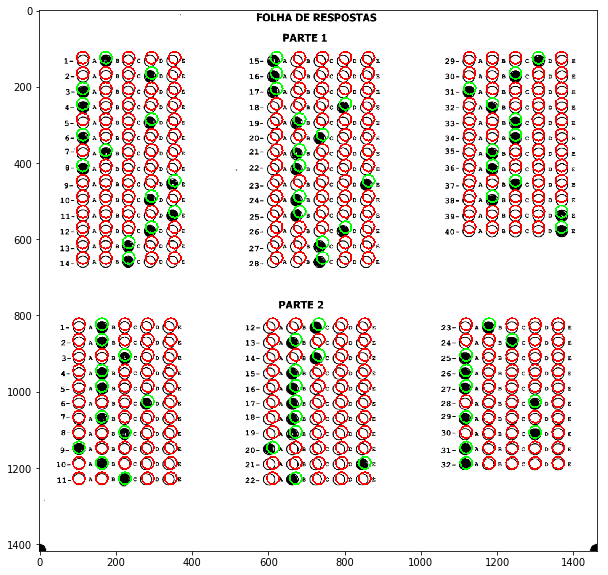

In [52]:
marked_options = marked_option(warped_img[int(0.34*h):][:], option_locations, imshow=True)

In [53]:
from sklearn.cluster import KMeans
closer = lambda myNumber, myList: min(myList, key=lambda x:abs(x-myNumber))
closer_index = lambda myNumber, myList: np.where(myList==closer(myNumber,myList))[0][0]

Xs = []
Ys = []
for option in marked_options:
    x,y = option[0]
    Xs.append([x])
    Ys.append([y])

x_means = KMeans(n_clusters=15, random_state=0).fit(Xs)
y_means = KMeans(n_clusters=24, random_state=0).fit(Ys)

xs = np.sort([int(x[0]) for x in x_means.cluster_centers_])
ys = np.sort([int(y[0]) for y in y_means.cluster_centers_])

answer_table = np.full([len(ys), len(xs)], -1)
for option in marked_options:
    x,y = option[0]
    answer_table[closer_index(y, ys)][closer_index(x, xs)] = option[1]
    
pd.DataFrame(answer_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
5,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
6,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
7,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
8,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
9,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [54]:
# part2 = 0
# division_lines = []

# for i,line in enumerate(answer_table):
#     if -1 in line:
#         division_lines.append(i)
        
# for i in range(len(division_lines)-1):
#     if division_lines[i+1] - division_lines[i] > 1:
#         part2 = division_lines[i]+1
#         break
        
answers =  [list(line[col:col+5]) for col in range(0,15,5) for line in answer_table[:part2]]
answers += [list(line[col:col+5]) for col in range(0,15,5) for line in answer_table[part2:]]

pd.DataFrame(answers).T

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0,0,1,1,0,1,0,1,0,0,...,0,1,1,1,0,1,0,1,1,-1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1
3,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,-1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1


In [55]:
abcde = "ABCDE"
answer_list = []

for q_line in answers:
    if not(-1 in q_line):
        if sum(q_line) > 1:
            answer_list.append('*')
        elif sum(q_line) == 0:
            answer_list.append('#')
        else:
            answer_list.append(abcde[q_line.index(1)])

df = pd.DataFrame(answer_list).T
df.to_csv("approach_testing.csv", index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,B,D,A,A,D,A,B,A,E,D,...,B,C,A,A,A,D,A,D,A,A
